In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torchvision.transforms as transformers
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import tqdm
device = torch.device('cuda:0')

In [8]:
def discretize(sample):
    return (sample * 255).to(torch.long)


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [9]:
batch_size = 64
transform = transformers.Compose([
    transformers.ToTensor(),
    discretize
])
train = torchvision.datasets.MNIST(
    '/home/fred/datasets/', train=True, transform=transform, download=False)
val = torchvision.datasets.MNIST(
    '/home/fred/datasets/', train=False, transform=transform, download=False)
trainLoader = torch.utils.data.DataLoader(
    train, batch_size, num_workers=1, pin_memory=True)
valLoader = torch.utils.data.DataLoader(
    val, batch_size, num_workers=1, pin_memory=True)

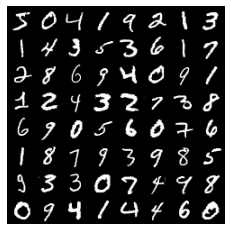

torch.Size([64, 1, 28, 28])


In [10]:
img, label = next(iter(trainLoader))
imshow(torchvision.utils.make_grid(img))
print(img.shape)

In [11]:
img[0]

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

In [6]:
class MaskedConvolution(nn.Module):

    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])

        self.conv = nn.Conv2d(c_in, c_out, kernel_size,
                              padding=padding, **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None, None])

    def forward(self, x):
        self.conv.weight.data *= self.mask  # Ensures zero's at masked positions
        return self.conv(x)

class VerticalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:, :] = 0

        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2, :] = 0

        super().__init__(c_in, c_out, mask, **kwargs)


class HorizontalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1, kernel_size)
        mask[0, kernel_size//2+1:] = 0

        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0, kernel_size//2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)


class GatedMaskedConv(nn.Module):

    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(
            c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(
            2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

In [7]:
class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(
            c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(
            c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(
            c_hidden, c_in * 256, kernel_size=1, padding=0)

        # self.example_input_array = train_set[0][0][None]

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(
            out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1, 2, 3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:, c, h, w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:, :, :h+1, :])
                    probs = F.softmax(pred[:, :, c, h, w], dim=-1)
                    img[:, c, h, w] = torch.multinomial(
                        probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)

In [8]:
def train_model(**kwargs):
    trainer = pl.Trainer(gpus=1,
                         max_epochs=60,
                         precision=16)

    model = PixelCNN(**kwargs)
    trainer.fit(model, trainLoader, valLoader)

    return model.to(device)

In [9]:
model = train_model(c_in=1, c_hidden=64)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                       | Params
-----------------------------------------------------------
0 | conv_vstack | VerticalStackConvolution   | 640   
1 | conv_hstack | HorizontalStackConvolution | 256   
2 | conv_layers | ModuleList                 | 834 K 
3 | conv_out    | Conv2d                     | 16.6 K
-----------------------------------------------------------
852 K     Trainable params
0         Non-trainable params
852 K     Total params
3.409     Total estimated model params size (MB)
/home/fred/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` ini

Validation sanity check: 0it [00:00, ?it/s]

/home/fred/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

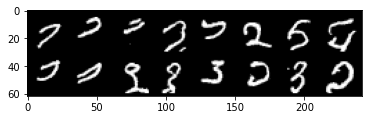

In [10]:
# model trained for 60 epoch
samples = model.sample((16, 1, 28, 28))
imshow(torchvision.utils.make_grid(samples.cpu()))

In [11]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()


def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:, 10:, :] = -1
    print("Original image and input image to sampling:")
    show_imgs([img, img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12, -1, -1, -1).to(device)
    pl.seed_everything(1)
    img_generated = model.sample(img_init.shape, img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)

/home/fred/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: No correct seed found, seed set to 1172635845
  warnings.warn(*args, **kwargs)
Global seed set to 1172635845


Original image and input image to sampling:


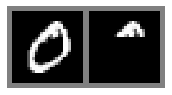

Global seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


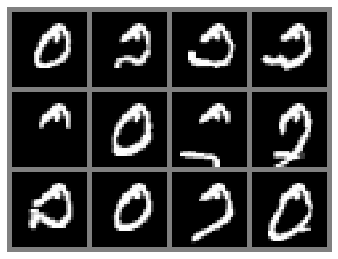

Original image and input image to sampling:


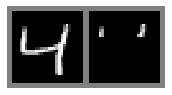

Global seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


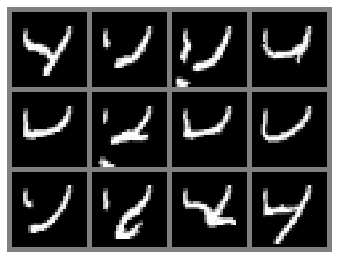

Original image and input image to sampling:


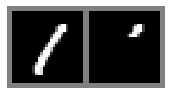

Global seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


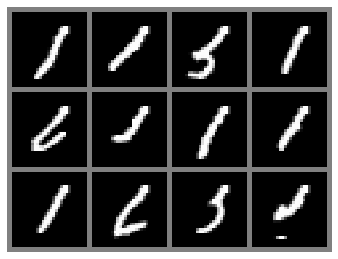

In [12]:
# model trained for 60 epoch
pl.seed_everything()
imgs, label = next(iter(trainLoader))
for i in range(4):
    img = imgs[i]
    autocomplete_image(img)

In [19]:
np.log2(np.exp(1))

1.4426950408889634

In [17]:
1/np.log(2)

1.4426950408889634